In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import uproot
from astropy.table import Table

In [2]:
scan = Table.read('../eyescan.dat', format='ascii')
ts_scan = scan.columns[2]
us_scan = scan.columns[3]

us_temp = []
for i in range(len(us_scan)): #keep first 5 digits of us to avoid a L2 round error
    u = int(us_scan[i]/10)
    us_temp.append(u)

label_scan = scan.columns[4]
ts_scan = np.array(ts_scan)
us_scan = np.array(us_temp)
label_scan = np.array(label_scan)

In [3]:
'''
#L2 root file
f = uproot.open('../../Reduced_data/L2Reduced_8-20NC_CALOR2017-19.root')
t = f['L2']['fTime'].array(library="np")
X = f['L2']['fCal/DetBranch/fX'].array(library="np")
Y = f['L2']['fCal/DetBranch/fY'].array(library="np")
Z = f['L2']['fCal/DetBranch/fZ'].array(library="np")
Adc = f['L2']['fCal/DetBranch/fAdc'].array(library="np")


ts, us = [], []
for i in range(len(t)):
    s = str(t[i])
    ts.append(int(s[0:10]))
    us.append(int(s[11:16]))
    
    if len(s[11:17]) ==5:
        us.append(int(s[11:17]+'0'))
    else:
        us.append(int(s[11:17]))
    
ts = np.array(ts)
us = np.array(us)
'''

#L1 root file
f = uproot.open('../../Reduced_data/L1Reduced_8-20NC_CALOR2017-19.root')
ts = f['L1']['L1 Flight']['ts'].array(library="np")
us = f['L1']['L1 Flight']['time[7]'].array(library="np")
X = f['L1']['L1 Shared']['calx'].array(library="np")
Y = f['L1']['L1 Shared']['caly'].array(library="np")
Z = f['L1']['L1 Shared']['calz'].array(library="np")
Adc = f['L1']['L1 Flight']['caladc'].array(library="np")

us_dummy = []
for i in range(len(us)):
    us_dummy.append(us[i][-1])
us = np.array(us_dummy)


In [4]:
label = []
for i in range(len(ts)):
    res = label_scan[ np.where( (ts_scan==ts[i]) & (us_scan==int(us[i]/10)) )[0] ]
    if len(res)==0:
        label.append(-1)
    else:
        label.append( int(res[0]) )
label = np.array(label)

In [5]:
#prepare for imgs
x_all, y_all, xz_all, yz_all = [], [], [], []
MeV_xz_all, MeV_yz_all = [],[]
for i in range(len(label)):
    
    x_idx = np.where(abs(X[i])>0.001)[0]
    y_idx = np.where(abs(Y[i])>0.001)[0]
    x_pos = X[i][x_idx]
    y_pos = Y[i][y_idx]
    xz_pos = Z[i][x_idx]
    yz_pos = Z[i][y_idx]
    
    MeV_xz = Adc[i][x_idx]
    invalid_x_idx = np.where(MeV_xz<0)[0] #set -9999 Adc to 0
    MeV_xz[invalid_x_idx] = 0
    
    MeV_yz = Adc[i][y_idx]
    invalid_y_idx = np.where(MeV_yz<0)[0] #set -9999 Adc to 0
    MeV_yz[invalid_y_idx] = 0
        
    x_all.append(x_pos)
    y_all.append(y_pos)
    xz_all.append(xz_pos)
    MeV_xz_all.append(MeV_xz)
    yz_all.append(yz_pos)
    MeV_yz_all.append(MeV_yz)

x_all = np.array(x_all, dtype=object)
y_all = np.array(y_all, dtype=object)
xz_all = np.array(xz_all, dtype=object)
yz_all = np.array(yz_all, dtype=object)
MeV_xz_all = np.array(MeV_xz_all, dtype=object)
MeV_yz_all = np.array(MeV_yz_all, dtype=object)

#save images
xz_imgs, yz_imgs = [],[]
for i in range(len(xz_all)):
    x_pix, y_pix = np.round(x_all[i]/10-0.5)+25.5, np.round(y_all[i]/10-0.5)+25.5
    xz_pix = np.round(xz_all[i]/4.55)-0.5
    yz_pix = np.round(yz_all[i]/4.55)-0.5

    xz_img, buf, buf = np.histogram2d(x_pix, xz_pix, weights=MeV_xz_all[i], bins=(range(51), range(21)) )   
    yz_img, buf, buf = np.histogram2d(y_pix, yz_pix, weights=MeV_yz_all[i], bins=(range(51), range(21)) ) 

    xz_imgs.append(xz_img) #for xzyz_img, normalize at the last
    yz_imgs.append(yz_img)
    
    #xz_imgs.append(xz_img/xz_img.sum())
    #yz_imgs.append(yz_img/yz_img.sum())
    
xz_imgs = np.array(xz_imgs)
yz_imgs = np.array(yz_imgs)



#merge xz and yz imgs
xzyz_imgs_vertical_dummy = []
xzyz_imgs_vertical = []

for i in range(len(xz_imgs)):
    xzyz_imgs_vertical_dummy.append(np.rot90(np.append(yz_imgs[i], xz_imgs[i], axis=1),1))
       
xzyz_imgs_vertical_dummy = np.array(xzyz_imgs_vertical_dummy)

for i in range(len(xzyz_imgs_vertical_dummy)):
    xzyz_imgs_vertical.append(xzyz_imgs_vertical_dummy[i]/xzyz_imgs_vertical_dummy[i].sum()) #sum norm

xzyz_imgs_vertical = np.array(xzyz_imgs_vertical)
 

#Save to numpy file
#np.save('../data/train_imgs_seperate.npy', [xz_imgs, yz_imgs])
#np.save('../data/train_label.npy', label)



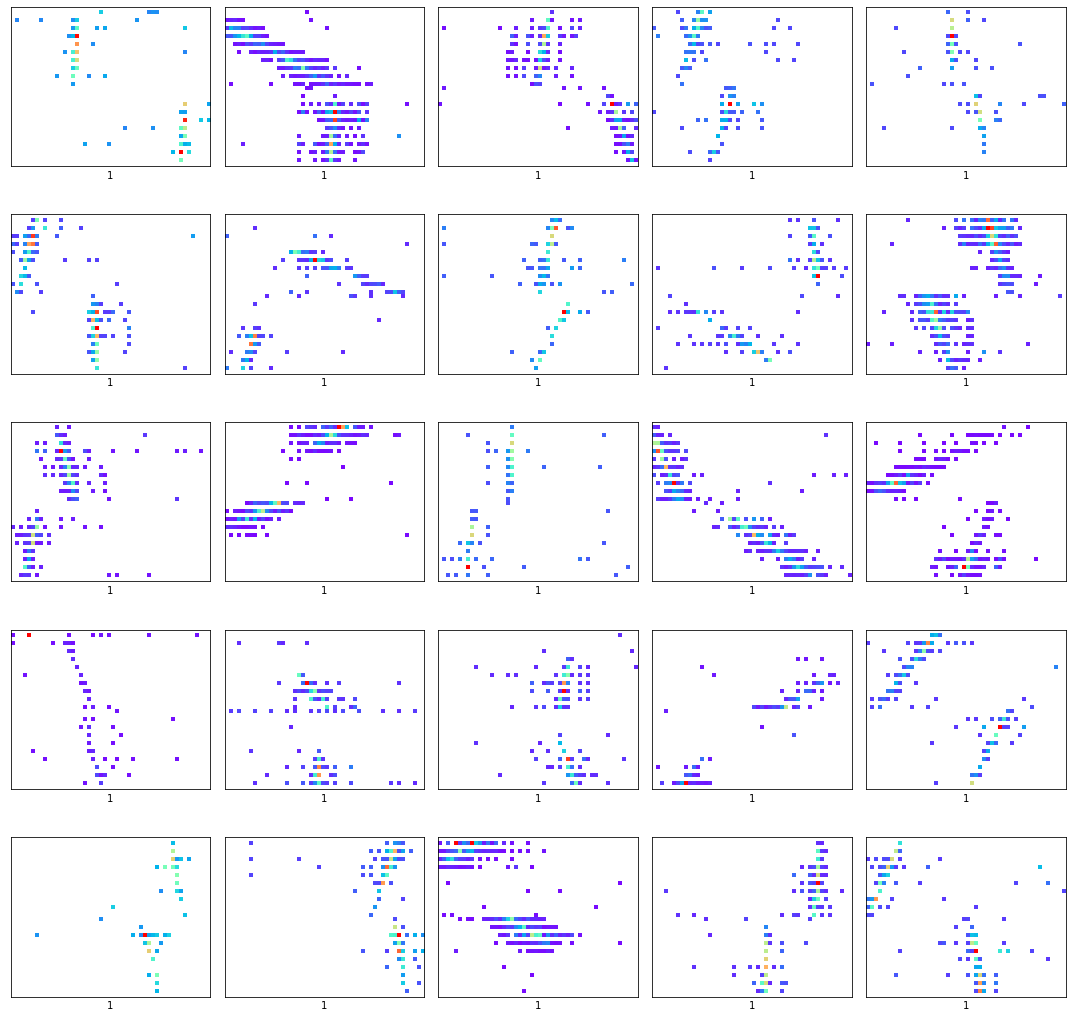

In [6]:
import matplotlib.pyplot as plt
import copy

def plot_image(label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    cmap = copy.copy(plt.cm.get_cmap("rainbow"))
    cmap.set_under(color='white') 
    plt.imshow(img, cmap=cmap, vmin=1e-7)
    
    plt.xlabel("%d" %(label))

num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(3*num_cols, 3*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    ns_idx = np.where(label==0)[0]
    cr_idx = np.where(label==1)[0]
    b=500
    plot_image(label[cr_idx][i+b], xzyz_imgs_vertical[cr_idx][i+b])
    
    plt.subplots_adjust(wspace = 0.5 )
plt.tight_layout()
plt.show()